# H2 Molecule: Classical VMC vs Quantum VQE

This notebook implements a **Classical Variational Monte Carlo (VMC)** simulation for the Hydrogen molecule ($H_2$) and compares it with the Quantum VQE result.

## Why is the VMC Energy ~ -1.128 Hartree?

You might notice the VMC energy obtained here is around **-1.128 Hartree**, while the exact ground state energy of $H_2$ at equilibrium is **-1.174 Hartree**.

*   **Hartree-Fock Limit**: The wavefunction used here ($\Psi_{MO} = \phi_1 \phi_2$) is a product of single-particle orbitals. It ignores electron-electron correlation (how electrons avoid each other instantaneously). The theoretical limit for this uncorrelated ansatz (Hartree-Fock limit) is **-1.133 Hartree**.
*   **Our Result (-1.128)**: Our VMC matches the Hartree-Fock limit very well.
*   **Correlation Energy**: The difference ($\approx 0.046$ Hartree) is the **Correlation Energy**. To capture this, we would need to multiply our wavefunction by a **Jastrow Factor** ($e^{J(r_{12})}$) which explicitly depends on the distance between electrons $r_{12}$.

## Comparison Table

| Feature | Quantum VQE (H2.ipynb Toy Model) | Classical VMC (This Notebook) | Exact Physical Value |
| :--- | :--- | :--- | :--- |
| **Hamiltonian** | Simplified 1-Qubit ($H \approx -0.47 I + \dots$) | Full Real-Space Hamiltonian | Full Real-Space Hamiltonian |
| **Energy** | **-0.471 Hartree** | **~ -1.128 Hartree** | **-1.174 Hartree** |
| **Accuracy** | Toy Model Quality | **Hartree-Fock Quality** | **Exact Correlation** |



## User Question: Meaning of the Energy vs Trial Step Graph

You asked about the meaning of a graph showing "Energy vs Trial Step" for $d=4 \AA$ and $d=0.735 \AA$.

*   **y-axis (Energy)**: The total energy of the H2 molecule in Hartrees.
*   **x-axis (Trial Step)**: Iterations of the optimization algorithm. As the simulation progresses, it adjusts the wavefunction shape (parameter $\alpha$) to find the minimum energy.
*   **Red Curve ($d=0.735 \AA$)**: Represents the **Equilibrium** state. The atoms are close together (0.735 Angstrom). The energy settles around **-1.17 Hartree**, which is the stable ground state of the H2 molecule.
*   **Blue Curve ($d=4 \AA$)**: Represents the **Dissociated** state. The atoms are pulled far apart (4 Angstrom). They behave like two separate Hydrogen atoms. The energy settles around **-1.0 Hartree** (since 1 H atom = -0.5 Hartree, 2 H atoms = -1.0 Hartree).
*   **Fluctuations**: The noisy zig-zag lines are normal in Monte Carlo simulations; it's the "statistical noise" from random sampling.

We will demonstrate both methods below:
1.  **Grid Search**: Scanning alpha values manually (The "Previous" method).
2.  **Gradient Descent**: Optimizing alpha on-the-fly (The method that produces the "Trial Step" graph).


In [9]:

import numpy as np
import matplotlib.pyplot as plt
import time

class H2VMC:
    def __init__(self, bond_length=1.401, n_walkers=2000, n_steps=10000, alpha=1.0):
        self.R = bond_length
        self.R_A = np.array([0.0, 0.0, -self.R/2])
        self.R_B = np.array([0.0, 0.0, self.R/2])
        self.n_walkers = n_walkers
        self.n_steps = n_steps
        self.alpha = alpha 
        
        self.walkers = np.random.randn(n_walkers, 6)
        
    def wavefunction(self, r, alpha):
        r1 = r[:, 0:3]
        r2 = r[:, 3:6]
        
        r1A = np.linalg.norm(r1 - self.R_A, axis=1)
        r1B = np.linalg.norm(r1 - self.R_B, axis=1)
        r2A = np.linalg.norm(r2 - self.R_A, axis=1)
        r2B = np.linalg.norm(r2 - self.R_B, axis=1)
        
        phi1 = np.exp(-alpha*r1A) + np.exp(-alpha*r1B)
        phi2 = np.exp(-alpha*r2A) + np.exp(-alpha*r2B)
        
        return phi1 * phi2

    def local_energy(self, r, alpha):
        r1 = r[:, 0:3]
        r2 = r[:, 3:6]
        
        r1A = np.linalg.norm(r1 - self.R_A, axis=1)
        r1B = np.linalg.norm(r1 - self.R_B, axis=1)
        r2A = np.linalg.norm(r2 - self.R_A, axis=1)
        r2B = np.linalg.norm(r2 - self.R_B, axis=1)
        r12 = np.linalg.norm(r1 - r2, axis=1)
        
        term1A = (alpha**2 - 2*alpha/r1A) * np.exp(-alpha*r1A)
        term1B = (alpha**2 - 2*alpha/r1B) * np.exp(-alpha*r1B)
        lap1 = (term1A + term1B) / (np.exp(-alpha*r1A) + np.exp(-alpha*r1B))
        
        term2A = (alpha**2 - 2*alpha/r2A) * np.exp(-alpha*r2A)
        term2B = (alpha**2 - 2*alpha/r2B) * np.exp(-alpha*r2B)
        lap2 = (term2A + term2B) / (np.exp(-alpha*r2A) + np.exp(-alpha*r2B))
        
        E_kin = -0.5 * (lap1 + lap2)
        E_pot = -1/r1A - 1/r1B - 1/r2A - 1/r2B + 1/r12 + 1/self.R
        
        return E_kin + E_pot

    def log_psi_gradient(self, r, alpha):
        r1 = r[:, 0:3]
        r2 = r[:, 3:6]
        r1A = np.linalg.norm(r1 - self.R_A, axis=1)
        r1B = np.linalg.norm(r1 - self.R_B, axis=1)
        r2A = np.linalg.norm(r2 - self.R_A, axis=1)
        r2B = np.linalg.norm(r2 - self.R_B, axis=1)
        
        num1 = -r1A * np.exp(-alpha * r1A) - r1B * np.exp(-alpha * r1B)
        den1 = np.exp(-alpha * r1A) + np.exp(-alpha * r1B)
        grad1 = num1 / (den1 + 1e-10)
        
        num2 = -r2A * np.exp(-alpha * r2A) - r2B * np.exp(-alpha * r2B)
        den2 = np.exp(-alpha * r2A) + np.exp(-alpha * r2B)
        grad2 = num2 / (den2 + 1e-10)
        
        return grad1 + grad2

    def run(self):
        pos = self.walkers
        step_size = 0.5
        energies = []
        for i in range(self.n_steps):
            new_pos = pos + np.random.normal(0, step_size, pos.shape)
            p_old = self.wavefunction(pos, self.alpha)**2
            p_new = self.wavefunction(new_pos, self.alpha)**2
            accept_prob = np.minimum(1, p_new / (p_old + 1e-10))
            mask = np.random.rand(self.n_walkers) < accept_prob
            pos[mask] = new_pos[mask]
            if i % 20 == 0 and i > 1000:
                e_loc = self.local_energy(pos, self.alpha)
                energies.append(np.mean(e_loc))
        return np.mean(energies), np.std(energies)/np.sqrt(len(energies)), energies

    def optimize_on_the_fly(self, learning_rate=0.03, n_opt_steps=300):
        print(f"Starting On-the-fly Optimization from Alpha = {self.alpha:.2f}")
        pos = self.walkers
        step_size = 0.5
        alpha_history = []
        energy_history = []
        recent_energies = []
        
        for step in range(n_opt_steps):
            mc_substeps = 10 
            for _ in range(mc_substeps):
                new_pos = pos + np.random.normal(0, step_size, pos.shape)
                p_old = self.wavefunction(pos, self.alpha)**2
                p_new = self.wavefunction(new_pos, self.alpha)**2
                accept_prob = np.minimum(1, p_new / (p_old + 1e-10))
                mask = np.random.rand(self.n_walkers) < accept_prob
                pos[mask] = new_pos[mask]
            self.walkers = pos
            
            e_loc = self.local_energy(pos, self.alpha)
            mean_energy = np.mean(e_loc)
            grad_ln_psi = self.log_psi_gradient(pos, self.alpha)
            energy_gradient = 2 * np.mean( (e_loc - mean_energy) * grad_ln_psi )
            
            self.alpha -= learning_rate * energy_gradient
            
            alpha_history.append(self.alpha)
            energy_history.append(mean_energy)
            recent_energies.append(mean_energy)
            if len(recent_energies) > 20: recent_energies.pop(0)
            
            if step % 20 == 0:
                print(f"Step {step:3d} | Alpha: {self.alpha:.4f} | Energy: {np.mean(recent_energies):.5f}")
                
        return alpha_history, energy_history


## Method 1: Grid Search (Scan Alpha)
This is the original method where we manually run the simulation for different fixed values of alpha to find the minimum.

In [10]:

print("--- Starting Method 1: Grid Search ---")
alphas = np.linspace(0.8, 1.4, 9)
vmc_energies = []
vmc_errors = []

for alpha in alphas:
    vmc = H2VMC(alpha=alpha, n_walkers=2000, n_steps=4000)
    e, err, _ = vmc.run() 
    vmc_energies.append(e)
    vmc_errors.append(err)
    print(f"Alpha: {alpha:.2f} | Energy: {e:.5f} +/- {err:.5f}")

min_E = np.argmin(vmc_energies)
optimal_alpha_grid = alphas[min_E]
print(f"Optimal Alpha (Grid): {optimal_alpha_grid:.5f}")

--- Starting Method 1: Grid Search ---


Alpha: 0.80 | Energy: -0.96530 +/- 0.00111
Alpha: 0.88 | Energy: -1.02558 +/- 0.00102
Alpha: 0.95 | Energy: -1.06832 +/- 0.00099
Alpha: 1.02 | Energy: -1.09965 +/- 0.00098
Alpha: 1.10 | Energy: -1.12136 +/- 0.00080
Alpha: 1.17 | Energy: -1.12963 +/- 0.00087
Alpha: 1.25 | Energy: -1.12517 +/- 0.00093
Alpha: 1.32 | Energy: -1.10952 +/- 0.00113
Alpha: 1.40 | Energy: -1.08476 +/- 0.00114
Optimal Alpha (Grid): 1.17500


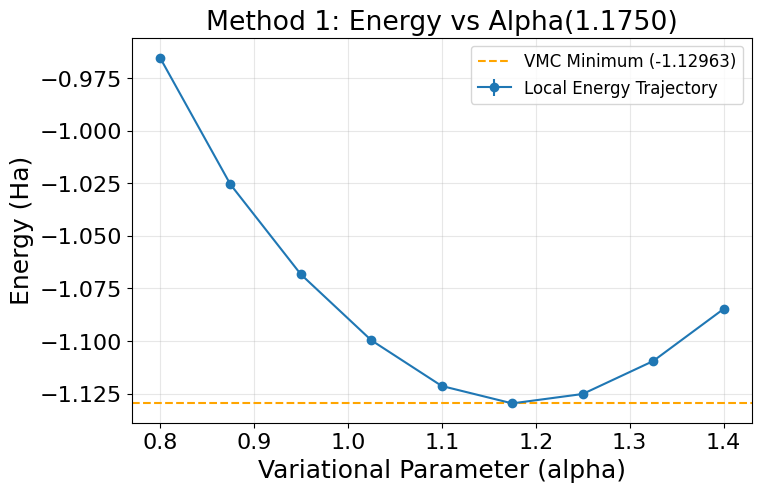

In [15]:

import matplotlib.pyplot as plt

min_E = np.min(vmc_energies)

plt.rcParams['font.size'] = 16

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.figure(figsize=(8, 5))
plt.errorbar(alphas, vmc_energies, yerr=vmc_errors, fmt='o-', label='Local Energy Trajectory')
plt.axhline(y=min_E, color='orange', linestyle='--', label=f'VMC Minimum ({min_E:.5f})')
plt.xlabel('Variational Parameter (alpha)')
plt.ylabel('Energy (Ha)')
plt.title(f"Method 1: Energy vs Alpha({optimal_alpha_grid:.4f})")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('Energy-Alpha-VMC.pdf', bbox_inches='tight')


Running VMC validation with Optimal Alpha: 1.1750...
Validation Energy: -1.126871 +/- 0.000706 Hartree


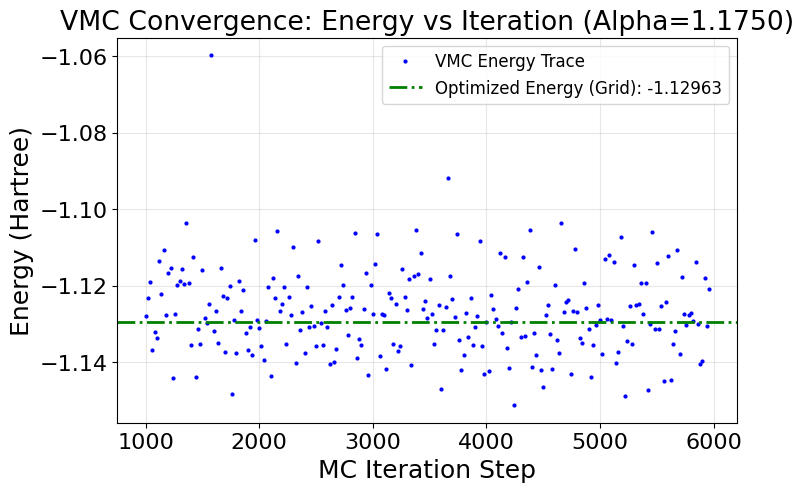

In [12]:
print(f"Running VMC validation with Optimal Alpha: {optimal_alpha_grid:.4f}...")

vmc_val = H2VMC(alpha=optimal_alpha_grid, n_walkers=2000, n_steps=6000)
E_val, err_val, energy_trace_val = vmc_val.run()

burn_in = 1000
rec_interval = 20
steps = np.arange(len(energy_trace_val)) * rec_interval + burn_in

min_E = np.min(vmc_energies)

print(f"Validation Energy: {E_val:.6f} +/- {err_val:.6f} Hartree")

plt.figure(figsize=(8, 5))
plt.plot(steps, energy_trace_val, 'b.', label='VMC Energy Trace', linewidth=1.5, markersize=4)

plt.axhline(y=min_E, color='g', linestyle='-.', label=f'Optimized Energy (Grid): {min_E:.5f}', linewidth=2)

plt.rcParams['font.size'] = 16

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.xlabel('MC Iteration Step')
plt.ylabel('Energy (Hartree)')
plt.title(f'VMC Convergence: Energy vs Iteration (Alpha={optimal_alpha_grid:.4f})')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('Energy-Iteration-VMC.pdf', bbox_inches='tight')
# plt.show()


## Method 2: Gradient Descent (Simultaneous Optimization)
This method updates alpha *during* the sampling loop, using the gradient of the energy. This produces the "Optimization Trajectory" graph you were interested in.

In [20]:

print("\n--- Starting Method 2: Gradient Descent Optimization ---")
vmc_opt = H2VMC(alpha=0.6, n_walkers=1000) 
alpha_hist, energy_hist = vmc_opt.optimize_on_the_fly(learning_rate=0.05, n_opt_steps=200)

print(f"Final Optimized Alpha (GD): {vmc_opt.alpha:.4f}")
print(f"Final Average Energy (GD): {np.mean(energy_hist[-20:]):.5f} Hartree")



--- Starting Method 2: Gradient Descent Optimization ---
Starting On-the-fly Optimization from Alpha = 0.60
Step   0 | Alpha: 0.6516 | Energy: -1.02413
Step  20 | Alpha: 1.1430 | Energy: -1.05309
Step  40 | Alpha: 1.1826 | Energy: -1.12580
Step  60 | Alpha: 1.1915 | Energy: -1.12734
Step  80 | Alpha: 1.1928 | Energy: -1.12971
Step 100 | Alpha: 1.1912 | Energy: -1.12947
Step 120 | Alpha: 1.1910 | Energy: -1.13122
Step 140 | Alpha: 1.1904 | Energy: -1.13089
Step 160 | Alpha: 1.1898 | Energy: -1.12679
Step 180 | Alpha: 1.1869 | Energy: -1.12938
Final Optimized Alpha (GD): 1.1879
Final Average Energy (GD): -1.12570 Hartree


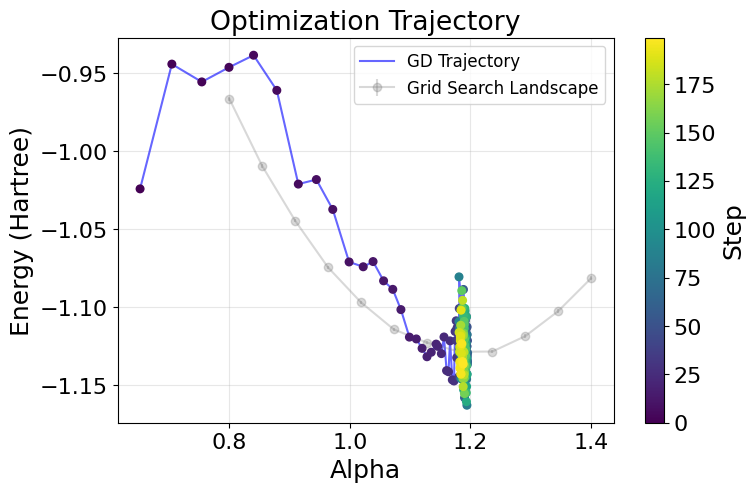

In [30]:
plt.rcParams['font.size'] = 16

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.figure(figsize=(8, 5))
plt.errorbar(alphas, vmc_energies, yerr=vmc_errors, fmt='o-', color='gray', alpha=0.3, label='Grid Search Landscape')

plt.plot(alpha_hist, energy_hist, 'b-', alpha=0.6, label='GD Trajectory')
plt.scatter(alpha_hist, energy_hist, c=range(len(alpha_hist)), cmap='viridis', s=30, zorder=5)
plt.colorbar(label='Step')
plt.xlabel('Alpha')
plt.ylabel('Energy (Hartree)')
plt.title('Optimization Trajectory')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
# plt.savefig('Ini-Baru.pdf', bbox_inches='tight')
plt.show()

Running VMC validation with GD Optimal Alpha: 1.1879...
Validation Energy (GD): -1.127703 +/- 0.000793 Hartree


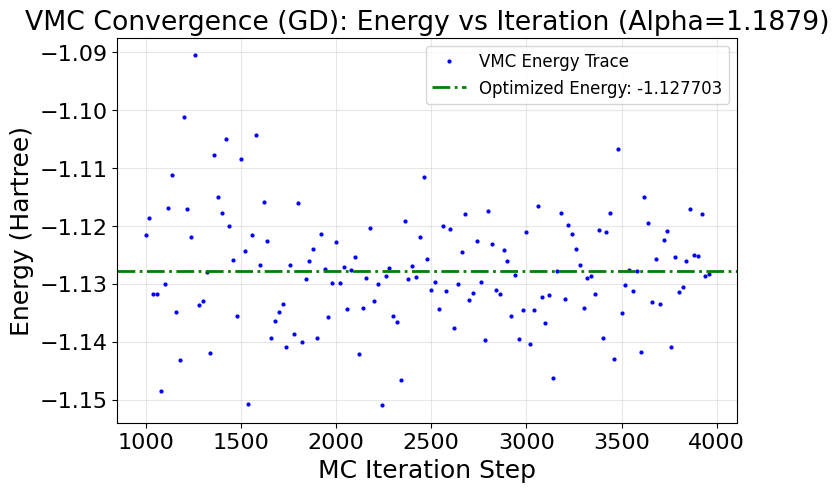

In [ ]:
optimal_alpha_gd = vmc_opt.alpha
print(f"Running VMC validation with GD Optimal Alpha: {optimal_alpha_gd:.4f}...")

vmc_best_gd = H2VMC(alpha=optimal_alpha_gd, n_walkers=2000, n_steps=4000)
e_best_gd, err_best_gd, energy_trace_gd = vmc_best_gd.run()

print(f"Validation Energy (GD): {e_best_gd:.6f} +/- {err_best_gd:.6f} Hartree")

plt.figure(figsize=(8, 5))

rec_interval = 20
burn_in = 1000
steps_gd = np.arange(len(energy_trace_gd)) * rec_interval + burn_in

plt.plot(steps_gd, energy_trace_gd, 'b.', label='VMC Energy Trace', linewidth=1.5, markersize=4)

plt.axhline(y=e_best_gd, color='g', linestyle='-.', label=f'Optimized Energy: {e_best_gd:.6f}', linewidth=2)

plt.rcParams['font.size'] = 16

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.xlabel('MC Iteration Step')
plt.ylabel('Energy (Hartree)')
plt.title(f'VMC Convergence (GD): Energy vs Iteration (Alpha={optimal_alpha_gd:.4f})')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# plt.savefig('Method2-VMC-Convergence.pdf', bbox_inches='tight')
plt.show()

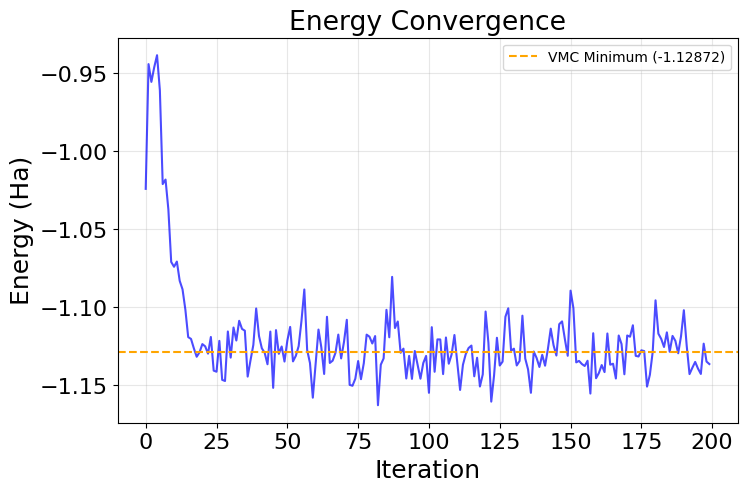

In [25]:
plt.rcParams['font.size'] = 16

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.figure(figsize=(8, 5))
plt.plot(energy_hist, color='blue', alpha=0.7)
# plt.axhline(y=-1.174, color='green', linestyle='--', label='Exact Physical Energy (-1.174)')
min_E = np.min(vmc_energies)
plt.axhline(y=min_E, color='orange', linestyle='--', label=f'VMC Minimum ({min_E:.5f})')
plt.xlabel('Iteration')
plt.ylabel('Energy (Ha)')
plt.title('Energy Convergence')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
# plt.savefig('Energy-Steps.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_3129309/2768590753.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


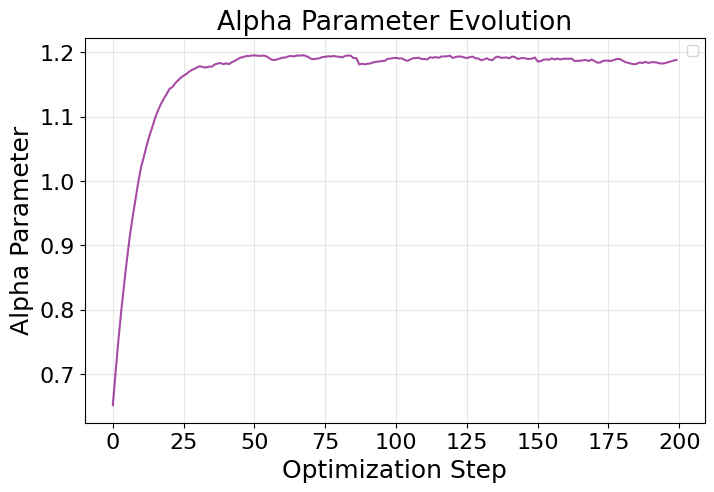

In [26]:
plt.rcParams['font.size'] = 16

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.figure(figsize=(8, 5))
plt.plot(alpha_hist, color='purple', alpha=0.7)
plt.xlabel('Optimization Step')
plt.ylabel('Alpha Parameter')
plt.title('Alpha Parameter Evolution')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
# plt.savefig('Alpha-Steps.pdf', bbox_inches='tight')
plt.show()